In [1]:
import os
import sys
sys.path.append("../../")

In [2]:
import torch
def load_obs_model(obs_type):
    from observation_model.obs_model import singleNN, cardinalNN

    if obs_type == 'single':
        obs_model = singleNN()
        obs_model.load_state_dict(torch.load("obs_model_4.pth", weights_only=True))
    elif obs_type == 'cardinal':
        obs_model = cardinalNN()
        obs_model.load_state_dict(torch.load("obs_model_cardinal_4.pth", weights_only=True))
    else:
        raise ValueError("Observation type not recognized")
    
    return obs_model

obs_model = load_obs_model(obs_type='single')  

In [7]:
from environment.env import POMDPDeformedGridworld
pomdp_env = POMDPDeformedGridworld()
pomdp_env.reset()

({'obs': tensor(1.), 'pos': tensor([0.6111, 0.3111])}, {})

# trajectory generation

In [ ]:
pomdp_env.reset()
print(pomdp_env.transformation_matrix)
s = pomdp_env.get_state()
pos = [s['pos']]
obs = [s['obs']]
previous_pos = pos[0]
while True:
    try:
        state, _, _, truncated, _ = pomdp_env.render()
        if state is not None:
            if not torch.all(torch.eq(state['pos'], previous_pos)):
                pos.append(state['pos'])
                obs.append(state['obs'])
                previous_pos = state['pos']
                predicted_obs = torch.distributions.Bernoulli(obs_model(state['pos'].unsqueeze(0),torch.tensor(pomdp_env.transformation_matrix).flatten().unsqueeze(0))).sample().squeeze()
                print(f"POS : {state['pos']}, OBS : {state['obs']}, PRED-OBS : {predicted_obs}")
    except:
        print('Error')
        break
    

[[0.7691541943327505, -0.11597286598416613], [-0.15776958567453014, 0.4927755725528012]]
POS : tensor([0.1344, 0.3401]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.1344, 0.3601]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.1144, 0.3601]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.1144, 0.3401]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.1344, 0.3401]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.1344, 0.3601]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.1144, 0.3601]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.1144, 0.3401]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.1344, 0.3401]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.1344, 0.3601]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.1144, 0.3601]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.1144, 0.3401]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.1344, 0.3401]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.1344, 0.3601]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.1144, 0.3601]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.1144, 0.3401]), OBS : 0.0

In [15]:
positions, observations = pos, obs
len(observations)

498

# VI L_a estimator

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal



def likelihood(X,y,theta):
    """
    y: observation
    X: position of the agent
    theta: deformation parameter (sampled from the variational distribution)
    
    Returns the log likelihood of the observation y given the position X and the deformation parameter theta
    """
    # print(X.shape, theta.shape)
    f_theta = obs_model(X, theta)
    return torch.distributions.Bernoulli(f_theta).log_prob(y).sum()

# Define the prior
def prior(theta):
    mu = torch.tensor([torch.mean(torch.tensor(pomdp_env.stretch_range)),
                    torch.mean(torch.tensor(pomdp_env.shear_range)),
                    torch.mean(torch.tensor(pomdp_env.shear_range)),
                    torch.mean(torch.tensor(pomdp_env.stretch_range))])
    sigma = torch.tensor([.5,.5,.5,.5])
    return Normal(mu, sigma).log_prob(theta).sum()

# Variational distribution (q_lambda)
class VariationalDistribution(nn.Module):
    def __init__(self, dim):
        super(VariationalDistribution, self).__init__()
        self.mu = nn.Parameter(torch.zeros(dim))
        self.log_sigma = nn.Parameter(torch.zeros(dim))
    
    def sample(self, num_samples=1):
        epsilon = torch.randn(num_samples, self.mu.size(0), device=self.mu.device)
        sigma = torch.exp(self.log_sigma)
        return self.mu + sigma * epsilon  # Reparameterization trick
    
    def log_prob(self, theta):
        sigma = torch.exp(self.log_sigma)
        return Normal(self.mu, sigma).log_prob(theta).sum()
    
    def entropy(self):
        sigma = torch.exp(self.log_sigma)
        return Normal(self.mu, sigma).entropy().sum()

# BBVI Training Loop
def bbvi(X, y, variational_dist, num_epochs=5000, num_samples=10, lr=0.01):
    optimizer = optim.Adam(variational_dist.parameters(), lr=lr)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Monte Carlo approximation of ELBO
        elbo = 0
        for i in range(num_samples):
            # Sample theta ~ q_lambda
            theta = variational_dist.sample()#(X.shape[0]) 
            theta = theta.repeat(X.shape[0],1)
            # Log likelihood p(x|theta) where theta is sampled from the variational distribution
            log_likelihood = likelihood(X,y,theta)
            
            # Log prior
            log_prior = prior(theta)
            
            # Log variational density
            log_q = variational_dist.log_prob(theta)
            
            # ELBO term
            elbo += log_likelihood + log_prior - log_q
        
        elbo /= num_samples  # Average over samples
        
        # Maximize ELBO (minimize negative ELBO)
        loss = -elbo
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, ELBO: {elbo.item():.4f}")
            print(f"Variational entropy: {variational_dist.entropy().item():.4f}")
    return variational_dist



In [58]:
# X va sostituito con gli stati del pomdp (x,y)
X = torch.stack(positions)

# y va sostituito con le osservazioni del pomdp negli stati pos=(x.y)
y = torch.stack(observations)

# true_theta va sostituito con i parametri reali del pomdp
true_theta = pomdp_env.transformation_matrix 

# print(X.shape, true_theta.shape, y.shape)

# Initialize variational distribution
variational_dist = VariationalDistribution(dim=4)

# Train with BBVI
trained_dist = bbvi(X, y, variational_dist, num_epochs=50, num_samples=500, lr=0.05)

# Output trained variational parameters
print(f"Variational Mean: {trained_dist.mu.detach().numpy()}")
print(f"Variational Log Std: {trained_dist.log_sigma.detach().numpy()}")

print(f"True Theta: {true_theta}")

Epoch 10, ELBO: -25962.5293
Variational entropy: 4.8743
Epoch 20, ELBO: -23939.4980
Variational entropy: 3.4748
Epoch 30, ELBO: -20333.4336
Variational entropy: 1.5732
Epoch 40, ELBO: -16172.3447
Variational entropy: -0.3459
Epoch 50, ELBO: -11909.1602
Variational entropy: -2.5454
Variational Mean: [ 1.0493237   0.05823155 -1.1842995   2.0302737 ]
Variational Log Std: [-1.9209076 -2.152432  -2.238774  -1.9090524]
True Theta: [[0.6856707071570237, 0.07479219888600463], [-0.05770537881008486, 0.8706924686393791]]


# L_B estimator

In [6]:
import torch
import torch.nn as nn
import torch.distributions as dist
from torch.optim import Adam
import numpy as np

class VariationalBayesianInference:
   
    def __init__(self, f, input_dim, latent_dim=1, hidden_dim=32):
        """
        Initialize the variational Bayesian inference model.
        
        Args:
            f: callable, the known function linking X and y through theta
            input_dim: int, dimension of input X
            latent_dim: int, dimension of latent parameter theta
            hidden_dim: int, dimension of hidden layers in the neural network
        """
        self.f = f
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Variational parameters (mean and log variance of q(theta))
        self.q_mu = nn.Parameter(torch.randn(latent_dim))
        self.q_logvar = nn.Parameter(torch.zeros(latent_dim))
        
        # Prior parameters (assumed to be standard normal)
        # self.prior = dist.Normal(torch.zeros(latent_dim), torch.ones(latent_dim))
        prior_mu = torch.tensor([torch.mean(torch.tensor(pomdp_env.stretch_range)),
                    torch.mean(torch.tensor(pomdp_env.shear_range)),
                    torch.mean(torch.tensor(pomdp_env.shear_range)),
                    torch.mean(torch.tensor(pomdp_env.stretch_range))])
        prior_sigma = torch.tensor([1,1,1,1])
        self.prior = dist.Normal(prior_mu, prior_sigma)
     
    def sample_latent(self, n_samples=1):
        """Sample from the variational distribution q(theta) 
           using the reparameterization trick
        """
        eps = torch.randn(n_samples, self.latent_dim)
        std = torch.exp(0.5 * self.q_logvar)
        return self.q_mu + eps * std
    
    def elbo(self, X, y, n_samples=10):
        """
        Compute the evidence lower bound (ELBO)
        
        Args:
            X: torch.Tensor, input data (batch_size, input_dim)
            y: torch.Tensor, observations (batch_size,)
            n_samples: int, number of Monte Carlo samples
        """
        batch_size = X.shape[0]
        
        # Sample from variational distribution
        theta_samples = self.sample_latent(n_samples)  # (n_samples, latent_dim)
        
        # Compute log likelihood for each sample
        log_likelihood = torch.zeros(n_samples, batch_size)
        for i in range(n_samples):
            theta = theta_samples[i]
            y_pred = self.f(X, theta.expand(batch_size, -1)).squeeze()
            # Assuming Bernoulli observation model
            log_likelihood[i] = dist.Bernoulli(y_pred).log_prob(y)
        
        # Average over samples
        expected_log_likelihood = torch.mean(log_likelihood, dim=0).sum()
        
        # Compute KL divergence
        q_dist = dist.Normal(self.q_mu, torch.exp(0.5 * self.q_logvar))
        kl_div = dist.kl_divergence(q_dist, self.prior).sum()
        
        return expected_log_likelihood - kl_div
    
    def elbo_bis(self, X, y, n_samples=10):
        """
        Compute the evidence lower bound (ELBO)
        
        Args:
            X: torch.Tensor, input data (batch_size, input_dim)
            y: torch.Tensor, observations (batch_size,)
            n_samples: int, number of Monte Carlo samples
        """
        batch_size = X.shape[0]
        
        # Sample from variational distribution
        theta_samples = self.sample_latent(n_samples * batch_size)  # (n_samples, latent_dim)
        
        # Compute log likelihood for each sample
        log_likelihood = torch.zeros(n_samples, batch_size)
        for i in range(0,n_samples*batch_size, batch_size):
            theta = theta_samples[i:i+batch_size]
            y_pred = self.f(X, theta).squeeze()
            # Assuming Bernoulli observation model
            log_likelihood[i//batch_size] = dist.Bernoulli(y_pred).log_prob(y)
        
        # Average over samples
        expected_log_likelihood = torch.mean(log_likelihood, dim=0).sum()
        
        # Compute KL divergence
        q_dist = dist.Normal(self.q_mu, torch.exp(0.5 * self.q_logvar))
        kl_div = dist.kl_divergence(q_dist, self.prior).sum()
        
        return expected_log_likelihood - kl_div
    
    def fit(self, X, y, n_epochs=100, batch_size=64, lr=0.1):
        """
        Fit the model using variational inference
        
        Args:
            X: torch.Tensor, input data
            y: torch.Tensor, observations
            n_epochs: int, number of training epochs
            batch_size: int, batch size for stochastic optimization
            lr: float, learning rate
        """
        optimizer = Adam([self.q_mu, self.q_logvar], lr=lr)
        
        dataset = torch.utils.data.TensorDataset(X, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        for epoch in range(n_epochs):
            epoch_loss = 0
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                loss = -self.elbo(batch_X, batch_y,1000)  # Negative because we minimize
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(dataloader):.4f}, Estimated theta mean: {self.q_mu.detach().numpy()}")
    
    def get_posterior_params(self):
        """Return the learned posterior parameters"""
        return {
            'mean': self.q_mu.detach(),
            'std': torch.exp(0.5 * self.q_logvar).detach()
        }

In [7]:
# X = posizione dell'agente (x,y)
X = torch.stack(positions)

# ossevrazioni dell'agente negli stati pos=(x,y)
y = torch.stack(observations)

# true_theta deformazione reale dell'ambiente
true_theta = pomdp_env.transformation_matrix 

# Create and fit the model
model = VariationalBayesianInference(obs_model, input_dim=2, latent_dim=4)
model.fit(X, y, n_epochs=1000, lr=0.05)

# Get the learned posterior parameters
posterior = model.get_posterior_params()
print("Estimated theta (mean):", posterior['mean'])
print("Posterior standard deviation:", posterior['std'])

print("True theta:", true_theta)

Epoch 10/1000, Loss: 161.7563, Estimated theta mean: [1.5059384 1.050783  1.3129802 0.76764  ]
Epoch 20/1000, Loss: 117.3716, Estimated theta mean: [1.5406835  1.6236666  1.1293     0.71412385]
Epoch 30/1000, Loss: 83.7235, Estimated theta mean: [1.0412105  1.9591649  0.87058944 0.868928  ]
Epoch 40/1000, Loss: 69.2291, Estimated theta mean: [0.8752959 2.25281   0.9327244 0.9237181]
Epoch 50/1000, Loss: 60.4352, Estimated theta mean: [0.9945076 2.4575832 1.2087976 0.9712483]
Epoch 60/1000, Loss: 54.5274, Estimated theta mean: [1.206824  2.5426342 1.4052323 1.0337088]


KeyboardInterrupt: 

In [9]:
# check likelihood of the observation given the estimated theta / true theta
# theta = torch.tensor([posterior['mean']])
theta = torch.tensor(pomdp_env.transformation_matrix).flatten()


y_pred = obs_model(X, theta.expand(X.shape[0], -1))
# # Assuming Bernoulli observation model
log_likelihood = dist.Bernoulli(y_pred.squeeze()).log_prob(y).mean()
log_likelihood


tensor(-0.0312, grad_fn=<MeanBackward0>)

# Bounded VI Beta prior / posterior


In [18]:
import torch
import torch.nn as nn
import torch.distributions as dist
from torch.optim import Adam
import numpy as np

class BetaVariationalBayesianInference:
    def __init__(self, f, input_dim, latent_dim=1, hidden_dim=32):
        """
        Initialize the variational Bayesian inference model with Beta distributions.
        
        Args:
            f: callable, the known function linking X and y through theta
            input_dim: int, dimension of input X
            latent_dim: int, dimension of latent parameter theta
            hidden_dim: int, dimension of hidden layers in the neural network
        """
        self.f = f
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Variational parameters (alpha and beta of q(theta))
        # Initialize to reasonable values (alpha=beta=2 gives a symmetric Beta)
        self.q_alpha = nn.Parameter(2 * torch.ones(latent_dim))
        self.q_beta = nn.Parameter(2 * torch.ones(latent_dim))
        
        # Prior parameters (can be customized)
        self.prior_alpha = torch.ones(latent_dim)  # Default to Beta(1,1) = Uniform(0,1)
        self.prior_beta = torch.ones(latent_dim)
        
        self.low = torch.tensor([.4, -.2, -.2, .4])
        self.high = torch.tensor([1.0, .2, .2, 1.0])

    def sample_latent(self, n_samples=1):
        """
        Sample from the variational distribution q(theta) using the Beta distribution
        """
        q_dist = dist.Beta(self.q_alpha, self.q_beta)
        theta =  q_dist.rsample((n_samples,))
        return self.low + (self.high - self.low) * theta
    
    def elbo(self, X, y, n_samples=10):
        """
        Compute the evidence lower bound (ELBO) with Beta distributions
        
        Args:
            X: torch.Tensor, input data (batch_size, input_dim)
            y: torch.Tensor, observations (batch_size,)
            n_samples: int, number of Monte Carlo samples
        """
        batch_size = X.shape[0]
        
        # Sample from variational distribution
        theta_samples = self.sample_latent(n_samples)  # (n_samples, latent_dim)
        
        # Compute log likelihood for each sample
        log_likelihood = torch.zeros(n_samples, batch_size)
        for i in range(n_samples):
            theta = theta_samples[i]
            y_pred = self.f(X, theta.expand(batch_size, -1)).squeeze()
            log_likelihood[i] = dist.Bernoulli(y_pred).log_prob(y)

        # Average over samples
        expected_log_likelihood = torch.mean(log_likelihood, dim=0).sum()
        
        # theta_expanded = theta.unsqueeze(1).expand(-1, batch_size, -1)  # Expand theta for batch computation
        # X_expanded = X.unsqueeze(0).expand(self.n_particles, -1, -1)  # Expand X for batch computation
        # print(X_expanded.shape, theta_expanded.shape)
        # y_pred = self.f(X_expanded, theta_expanded,dim=2)  # Shape: (n_particles, batch_size)
        # y_pred = y_pred.squeeze()  # Adjust shape if needed
        # log_likelihoods = dist.Bernoulli(y_pred).log_prob(y.unsqueeze(0)).sum(dim=-1)  # Sum over batch size
        
        # expected_log_likelihoods = log_likelihoods.mean(dim=0).sum()
        # assert expected_log_likelihood == expected_log_likelihoods
        # Compute KL divergence between Beta distributions
        q_dist = dist.Beta(self.q_alpha, self.q_beta)
        prior_dist = dist.Beta(self.prior_alpha, self.prior_beta)
        kl_div = dist.kl_divergence(q_dist, prior_dist).sum()
        
        return expected_log_likelihood - kl_div
    
    def fit(self, X, y, n_epochs=100, batch_size=64, lr=0.1):
        """
        Fit the model using variational inference
        
        Args:
            X: torch.Tensor, input data
            y: torch.Tensor, observations
            n_epochs: int, number of training epochs
            batch_size: int, batch size for stochastic optimization
            lr: float, learning rate
        """
        optimizer = Adam([self.q_alpha, self.q_beta], lr=lr)
        
        dataset = torch.utils.data.TensorDataset(X, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
        self.entropy = []
        for epoch in range(n_epochs):
            epoch_loss = 0
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                loss = -self.elbo(batch_X, batch_y, n_samples=300)  # Negative because we minimize
                loss.backward()
                optimizer.step()
                
                # Ensure parameters stay positive
                with torch.no_grad():
                    self.q_alpha.data.clamp_(min=1e-6)
                    self.q_beta.data.clamp_(min=1e-6)
                
                epoch_loss += loss.item()
            
            current_entropy = dist.Beta(self.q_alpha.detach(), self.q_beta.detach()).entropy().sum()
            self.entropy.append(current_entropy.item())    
            if (epoch + 1) % 10 == 0:
                mean = self.q_alpha.detach() / (self.q_alpha.detach() + self.q_beta.detach())
                mean = self.low + (self.high - self.low) * mean
                print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")
                print(f"Estimated theta mean: {mean}")
                print(f"Entropy: {current_entropy.item()}")
    
    def get_posterior_params(self):
        """Return the learned posterior parameters"""
        return {
            'alpha': self.q_alpha.detach(),
            'beta': self.q_beta.detach(),
            'mean': self.low + (self.high - self.low) * (self.q_alpha / (self.q_alpha + self.q_beta)).detach(),
            'mode': ((self.q_alpha - 1) / (self.q_alpha + self.q_beta - 2)).detach()
        }

In [19]:
# X = posizione dell'agente (x,y)
X = torch.stack(positions)

# ossevrazioni dell'agente negli stati pos=(x,y)
y = torch.stack(observations)

# true_theta deformazione reale dell'ambiente
true_theta = pomdp_env.transformation_matrix 

# Create and fit the model
model = BetaVariationalBayesianInference(obs_model, input_dim=2, latent_dim=4)
model.fit(X, y, n_epochs=100, lr=0.05)

# Get the learned posterior parameters
posterior = model.get_posterior_params()
print("Estimated Posterior mean ", posterior['mean'])
print("True theta:", true_theta)

Epoch 10/100, Loss: 162.0081
Estimated theta mean: tensor([ 0.6878, -0.0027, -0.0662,  0.5979])
Entropy: -0.7755717039108276
Epoch 20/100, Loss: 164.6250
Estimated theta mean: tensor([ 0.6598,  0.0026, -0.0704,  0.5986])
Entropy: -0.891624927520752


KeyboardInterrupt: 

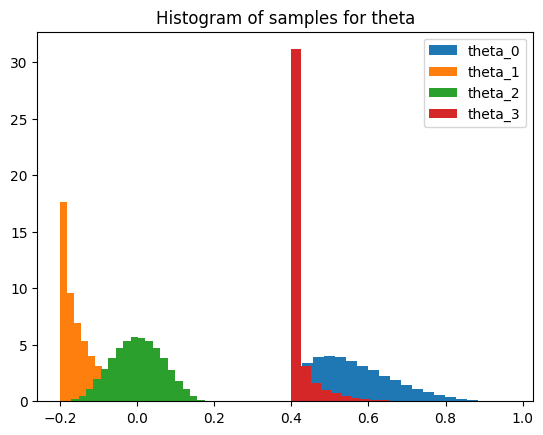

Mean of theta_1: 0.4198075830936432
distribution mean: tensor([ 0.5629, -0.1447,  0.0015,  0.4199], grad_fn=<AddBackward0>)


In [63]:
# q_alpha = 2 * torch.ones(4)   
# q_beta = 2 * torch.ones(4)
q_alpha = model.q_alpha
q_beta = model.q_beta

low = torch.tensor([.4, -.2, -.2, .4])
high = torch.tensor([1.0, .2, .2, 1.0])

def sample_latent(n_samples=1):
    """
    Sample from the variational distribution q(theta) using the Beta distribution
    """
    q_dist = dist.Beta(q_alpha, q_beta)
    theta =  q_dist.rsample((n_samples,))
    return low + (high - low) * theta

# plot the samples
import matplotlib.pyplot as plt


samples = sample_latent(100000)
for i in range(4):
    plt.hist(samples[:,i].detach().numpy(), bins=20, density=True)
plt.title(f"Histogram of samples for theta")
plt.legend([f"theta_{i}" for i in range(4)])
plt.show()


mean = q_alpha / (q_alpha + q_beta)
print("distribution mean:", low + (high - low) * mean)

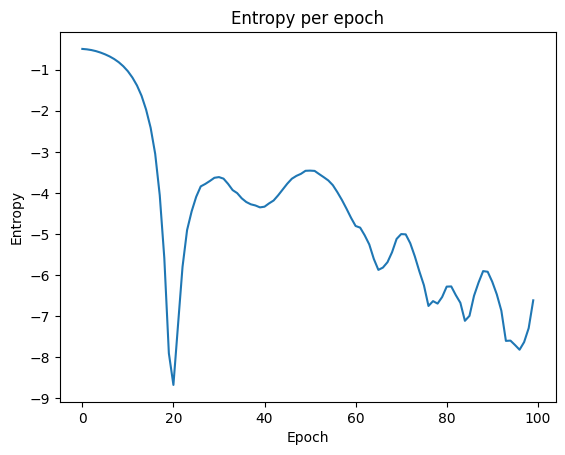

In [65]:
# plot model entropy per epoch
plt.plot(model.entropy)
plt.title("Entropy per epoch")
plt.xlabel("Epoch")
plt.ylabel("Entropy")
plt.show()


# Particle Filter

In [24]:
import torch
import torch.distributions as dist
import numpy as np

class BayesianParticleFilter:
    def __init__(self, f, n_particles=1000, theta_dim=2):
        """
        Initialize the particle filter for Bayesian linear regression with 2D parameters.
        
        Args:
            n_particles (int): Number of particles to use for approximating the posterior.
            theta_dim (int): Dimensionality of the parameter vector (default is 2).
        """
        self.f = f
        self.n_particles = n_particles
        self.theta_dim = theta_dim
        self.particles = None
        self.weights = None

        self.low = torch.tensor([.4, -.2, -.2, .4])
        self.high = torch.tensor([1.0, .2, .2, 1.0])

        
    def initialize_particles(self, prior_mean=0.0, prior_std=1.0):
        """
        Initialize particles from the prior distribution.
        
        Args:
            prior_mean (float): Mean of the prior distribution.
            prior_std (float): Standard deviation of the prior distribution.
        """
        # Sample initial particles from a multivariate Gaussian prior
        self.particles = torch.normal(
            prior_mean, prior_std, size=(self.n_particles, self.theta_dim)
        )

        self.q_alpha = torch.nn.Parameter(2 * torch.ones(4))
        self.q_beta = torch.nn.Parameter(2 * torch.ones(4))

        beta = dist.Beta(self.q_alpha, self.q_beta)
        self.particles = self.low + (self.high - self.low) * beta.sample((self.n_particles,))

        # Initialize uniform weights
        self.weights = torch.ones(self.n_particles) / self.n_particles
        
    def log_likelihood(self, X, y, theta, noise_std=0.1):
        """
        Compute the log likelihood log p(y|X,theta) assuming Gaussian noise.
        
        Args:
            X (torch.Tensor): Input features (n_samples, 2).
            y (torch.Tensor): Target values (n_samples,).
            theta (torch.Tensor): Parameter particles (n_particles, theta_dim).
            noise_std (float): Standard deviation of observation noise.
        
        Returns:
            torch.Tensor: Log likelihood values for each particle.
        """
        batch_size = X.shape[0]
        
        # # Compute log likelihood for each sample
        # log_likelihoods = torch.zeros(self.n_particles)
        # for i in range(self.n_particles):
        #     t = theta[i]
        #     y_pred = self.f(X, t.expand(batch_size, -1)).squeeze()
        #     log_likelihoods[i] = dist.Bernoulli(y_pred).log_prob(y).sum()
        

        ########### test
        # Compute log likelihood for each sample in parallel
        theta_expanded = theta.unsqueeze(1).expand(-1, batch_size, -1)  # Expand theta for batch computation
        X_expanded = X.unsqueeze(0).expand(self.n_particles, -1, -1)  # Expand X for batch computation
        y_pred = self.f(X_expanded, theta_expanded,dim=2)  # Shape: (n_particles, batch_size)
        y_pred = y_pred.squeeze()  # Adjust shape if needed
        log_likelihoods = dist.Bernoulli(y_pred).log_prob(y.unsqueeze(0)).sum(dim=-1)  # Sum over batch size
        ###########
        # Average over samples
        return log_likelihoods
        
    def update(self, X, y, noise_std=0.1):
        """
        Update particle weights based on new observations.
        
        Args:
            X (torch.Tensor): Input features (n_samples, theta_dim).
            y (torch.Tensor): Target values (n_samples,).
            noise_std (float): Standard deviation of observation noise.
        """
        # Compute log likelihood for each particle
        log_likelihoods = self.log_likelihood(X, y, self.particles, noise_std)

        # Update log weights
        log_weights = torch.log(self.weights) + log_likelihoods
        
        # Subtract maximum for numerical stability before exp
        log_weights_normalized = log_weights - torch.max(log_weights)
        self.weights = torch.exp(log_weights_normalized)
        
        # Normalize weights
        self.weights /= self.weights.sum()
        
        # Compute effective sample size
        eff_sample_size = 1.0 / (self.weights ** 2).sum()
        
        # Resample if effective sample size is too low
        if eff_sample_size < self.n_particles / 2:
            self.resample()
    
    def resample(self):
        """
        Resample particles according to their weights using systematic resampling.
        """
        # Compute cumulative sum of weights
        cumsum = torch.cumsum(self.weights, dim=0)
        
        # Generate systematic resampling points
        u = torch.rand(1)
        positions = (u + torch.arange(self.n_particles)) / self.n_particles
        
        # Resample particles
        indices = torch.searchsorted(cumsum, positions)
        self.particles = self.particles[indices]
        
        # Reset weights to uniform
        self.weights = torch.ones(self.n_particles) / self.n_particles
    
    def estimate_posterior(self):
        """
        Compute posterior mean and variance from particles.
        
        Returns:
            tuple: (posterior_mean, posterior_variance)
        """
        posterior_mean = (self.particles.T * self.weights).sum(dim=1)
        posterior_var = ((self.particles - posterior_mean) ** 2).T * self.weights
        posterior_var = posterior_var.sum(dim=1)
        posterior_likelihood = self.log_likelihood(X, y, self.particles)
        return posterior_mean.detach().numpy(), posterior_var.detach().numpy(), posterior_likelihood.detach().numpy().mean()



In [25]:
# X = posizione dell'agente (x,y)
X = torch.stack(positions)

# ossevrazioni dell'agente negli stati pos=(x,y)
y = torch.stack(observations)

# true_theta deformazione reale dell'ambiente
true_theta = pomdp_env.transformation_matrix 

# Create and fit the model
n_particles = 500
pf = BayesianParticleFilter(f = obs_model, n_particles=n_particles, theta_dim=4)
pf.initialize_particles()
prior_likelihood = pf.log_likelihood(X, y, pf.particles).mean()

# Update particle filter with observations
%timeit pf.update(X, y)

posterior_mean, posterior_var, posterior_likelihood = pf.estimate_posterior()
print("Posterior Mean:", posterior_mean)
print("Posterior Variance:", posterior_var)
print("Posterior Likelihood:", posterior_likelihood)
print("True Parameters:", true_theta)
print("prior likelihood", prior_likelihood)

# relative_error = np.linalg.norm(posterior_mean - theta_true) / np.linalg.norm(theta_true)
# print("Relative Error:", relative_error)

67 ms ± 4.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Posterior Mean: [ 0.47551093  0.11829136 -0.07266098  0.9606611 ]
Posterior Variance: [3.1974430e-14 0.0000000e+00 2.2204460e-16 3.5527137e-15]
Posterior Likelihood: -48.374573
True Parameters: [[0.5159853993143302, 0.07097860961327107], [0.05650267305380735, 0.8815503012805062]]
prior likelihood tensor(-563.0644, grad_fn=<MeanBackward0>)


In [9]:
X = torch.rand(10,15,2)
theta = torch.rand(10,15,4)
y = torch.cat([X, theta], dim=2)
obs_model(X, theta,dim=2).shape

torch.Size([10, 15, 1])

# Laplace

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import numpy as np
import matplotlib.pyplot as plt

class BernoulliModel(nn.Module):
    def __init__(self, n_features, obs_model):
        """
        Initialize the Bernoulli model
        
        Parameters:
        n_features (int): Number of input features
        """
        super().__init__()
        self.beta = nn.Parameter(torch.ones(n_features)/4,requires_grad=True)
        self.obs_model = obs_model
        
        # freeze the weights of the observation model
        for param in self.obs_model.parameters():
            param.requires_grad = False
        
    
    def forward(self, X):
        """
        Compute the Bernoulli distribution
        """
        probs = self.obs_model(X, self.beta.expand(X.shape[0], -1)).squeeze()
        return dist.Bernoulli(probs=probs)

class LaplaceApproximation:
    def __init__(self, X, y, obs_model, device='cpu'):
        """
        Initialize the Laplace Approximation for Bayesian Logistic Regression
        
        Parameters:
        X (array-like): Feature matrix
        y (array-like): Binary target variable (0 or 1)
        device (str): 'cpu' or 'cuda'
        """
        self.device = device
        self.X = X
        self.y = y
        
        self.n_features = 4
        
        # Initialize model
        self.model = BernoulliModel(self.n_features,obs_model).to(device)
        
    def negative_log_posterior(self):
        """
        Compute the negative log posterior (up to a constant)
        """
        # Prior (standard normal)
        prior = dist.Normal(0, 1)
        log_prior = prior.log_prob(self.model.beta).sum()
        
        # Likelihood (Bernoulli) given current beta
        bernoulli_dist = self.model(self.X)
        log_likelihood = bernoulli_dist.log_prob(self.y).sum()
        
        return -(log_prior + log_likelihood)
    
    def fit(self, n_epochs=1000, lr=0.1):
        """
        Perform Laplace approximation
        
        Parameters:
        n_epochs (int): Number of optimization iterations
        lr (float): Learning rate for optimization
        """
        # Find MAP estimate using Adam optimizer
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            loss = self.negative_log_posterior()
            loss.backward()
            optimizer.step()
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

        self.beta_map = self.model.beta.detach().clone()
        
        # Compute Hessian at MAP using autograd
        hessian = torch.zeros((self.n_features, self.n_features)).to(self.device)
        
        for i in range(self.n_features):
            self.model.zero_grad()
            loss = self.negative_log_posterior()
            grad = torch.autograd.grad(loss, self.model.beta, create_graph=True)[0]
            
            for j in range(self.n_features):
                hessian[i,j] = torch.autograd.grad(grad[j], self.model.beta, retain_graph=True)[0][i]
        
        # Posterior covariance is inverse of Hessian
        self.posterior_cov = torch.inverse(hessian).cpu().numpy()
        self.beta_map = self.beta_map.cpu().numpy()
    
    def predict_proba(self, X_new, n_samples=1000):
        """
        Predict probabilities and generate samples for new data points
        
        Parameters:
        X_new (array-like): New feature matrix
        n_samples (int): Number of samples to draw from approximate posterior
        """
        X_new = torch.tensor(X_new, dtype=torch.float32)
        
        # Draw samples from approximate posterior
        beta_samples = torch.tensor(
            np.random.multivariate_normal(self.beta_map, self.posterior_cov, n_samples),
            dtype=torch.float32
        )
        
        # Compute probabilities and draw samples for each beta
        all_probs = []
        all_samples = []
        
        for beta in beta_samples:
            linear_pred = X_new @ beta
            probs = torch.sigmoid(linear_pred)
            bernoulli_dist = dist.Bernoulli(probs=probs)
            
            all_probs.append(probs.numpy())
            all_samples.append(bernoulli_dist.sample().numpy())
        
        # Calculate statistics
        probs = np.array(all_probs)
        samples = np.array(all_samples)
        
        mean_probs = np.mean(probs, axis=0)
        lower = np.percentile(probs, 2.5, axis=0)
        upper = np.percentile(probs, 97.5, axis=0)
        
        return mean_probs, lower, upper, samples

# Test the implementation
if __name__ == "__main__":
    # Set random seeds for reproducibility
    torch.manual_seed(np.random.randint(31985))
    np.random.seed(np.random.randint(31985))
    
    # Generate synthetic data
    n_features = 2

    # X = posizione dell'agente (x,y)
    X = torch.stack(positions)

    # ossevrazioni dell'agente negli stati pos=(x,y)
    y = torch.stack(observations)

    # true_theta deformazione reale dell'ambiente
    true_beta = torch.tensor(pomdp_env.transformation_matrix)

    # Fit model
    model = LaplaceApproximation(X, y, obs_model)
    model.fit(n_epochs=100, lr=0.04)
    
    # Print results
    print("\nResults:")
    print("True parameters:", true_beta.numpy())
    print("MAP estimate:", model.beta_map)
    # print("Relative Error:", torch.norm(torch.tensor(model.beta_map) - true_beta) / torch.norm(true_beta))
    print("Posterior standard deviations:", np.sqrt(np.diag(model.posterior_cov)))



Epoch 0, Loss: 1243.6029
Epoch 10, Loss: 617.1367
Epoch 20, Loss: 237.2477
Epoch 30, Loss: 232.2565
Epoch 40, Loss: 219.3353
Epoch 50, Loss: 219.0651
Epoch 60, Loss: 215.6602
Epoch 70, Loss: 211.4000
Epoch 80, Loss: 211.5469
Epoch 90, Loss: 211.0172

Results:
True parameters: [[ 0.7964388  -0.1261892 ]
 [ 0.16433951  0.88892126]]
MAP estimate: [0.5188594  0.14092042 0.525599   0.6289252 ]
Posterior standard deviations: [0.0085637  0.00599304 0.00738276 0.00634734]


In [59]:
bernoulli = BernoulliModel(4, obs_model)
# bernoulli.beta = torch.nn.Parameter(torch.tensor(pomdp_env.transformation_matrix).flatten())
bernoulli(X).log_prob(y).sum()

tensor(-1275.3907, grad_fn=<SumBackward0>)

In [37]:
prior = dist.Normal(0, 1)
log_prior = prior.log_prob(bernoulli.beta).sum()

log_prior

tensor(-4.4095, grad_fn=<SumBackward0>)

# Discrete vs VI

In [66]:
discretization = 20

stretch = np.linspace(.4, 1, discretization)
shear = np.linspace(-.2,.2, discretization)
xa,ya,yb,xb = np.meshgrid(stretch, shear,shear,stretch) # , shear, shear
theta_param = np.column_stack([xa.ravel(),ya.ravel(),yb.ravel(),xb.ravel()]),
theta_param = torch.tensor(np.array(theta_param), dtype=torch.float32)
belief_points = theta_param.squeeze()
belief_values = torch.ones(belief_points.shape[0], dtype=torch.float32, requires_grad=False) / len(theta_param)


def discrete_belief_update(belief_values,pomdp_state):
    """discrete belief update"""
    pos = pomdp_state['pos']
    obs = pomdp_state['obs']

    batch_pos = pos.repeat(len(belief_points), 1)

    with torch.no_grad():
        predictions = obs_model(batch_pos,belief_points)

    likelihood = torch.exp(torch.distributions.Bernoulli(predictions).log_prob(obs))

    tmp = likelihood.squeeze() * belief_values
    belief_values = tmp  / tmp.sum()


    return belief_values

entropy = []
for s in zip(positions,observations):
    belief_values = discrete_belief_update(belief_values,{'pos':s[0],'obs':s[1]})
    # entropy.append(-torch.sum(belief_values * torch.log(belief_values + 1e-16)).item())
    entropy.append(torch.distributions.Categorical(belief_values).entropy().item())

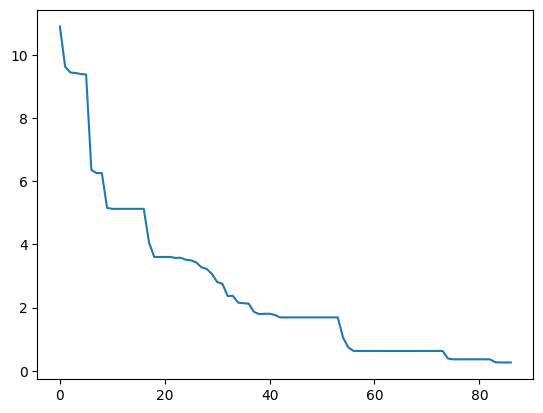

In [67]:
# plot the entropy
plt.plot(entropy)

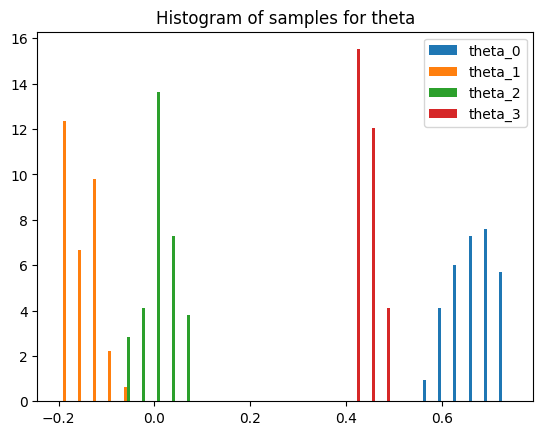

In [69]:
samples = belief_points[torch.multinomial(belief_values, 100)] # sample from the belief

# plot the distribution
plt.hist(samples.numpy(), bins=30, density=True)
plt.title(f"Histogram of samples for theta")
plt.legend([f"theta_{i}" for i in range(4)])
plt.show()


# metropolis

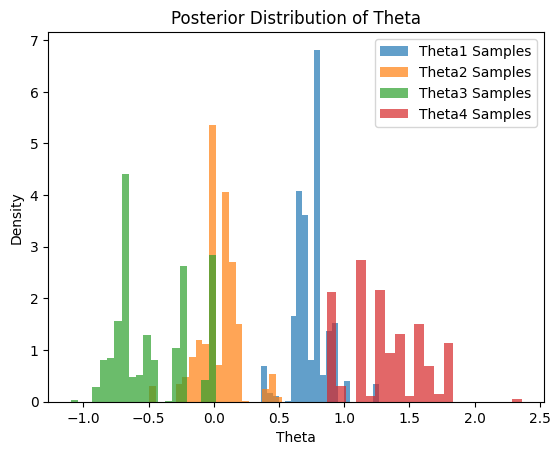

Mean of theta1: 0.7420249581336975
Mean of theta2: 0.03706667572259903
Mean of theta3: -0.46467968821525574
Mean of theta4: 1.3048193454742432
[[0.6856707071570237, 0.07479219888600463], [-0.05770537881008486, 0.8706924686393791]]


In [98]:
import torch
import torch.distributions as dist

# Define the multivariate Gaussian prior: N(mu, Sigma)
def prior(theta, mu, sigma):
    """
    theta: Tensor of shape (2,) representing [theta1, theta2].
    mu: Tensor of shape (2,) representing [mu1, mu2].
    sigma: Tensor of shape (2, 2), covariance matrix.
    """
    mvn = dist.MultivariateNormal(mu, sigma)
    return mvn.log_prob(theta)

def likelihood(X,theta,y):
    """
    y: observation
    X: position of the agent
    theta: deformation parameter (sampled from the variational distribution)
    
    Returns the log likelihood of the observation y given the position X and the deformation parameter theta
    """
    # print(X.shape, theta.shape)
    y_pred = obs_model(X, theta.repeat(X.shape[0],1)).squeeze()
    return dist.Bernoulli(y_pred).log_prob(y)


# Define the posterior (up to proportionality)
def log_posterior(X,theta, y, mu, sigma):
    """
    theta: Tensor of shape (2,) representing [theta1, theta2].
    """
    return likelihood(X,theta, y).sum() + prior(theta, mu, sigma)

# Metropolis-Hastings algorithm
def metropolis_hastings(X,y, num_samples=10000, burn_in=1000, mu=None, sigma=None, proposal_std=0.5):
    """
    y: Observed binary outcomes (0 or 1).
    num_samples: Number of samples to draw from posterior.
    burn_in: Number of initial samples to discard.
    mu: Tensor of shape (2,) representing the prior mean vector.
    sigma: Tensor of shape (2, 2), the prior covariance matrix.
    proposal_std: Standard deviation for the proposal distribution.
    """
    if mu is None:
        raise ValueError("Prior mean (mu) must be specified.")
        mu = torch.tensor([0.0, 0.0])
    if sigma is None:
        sigma = torch.eye(2)  # Identity covariance matrix by default

    samples = []
    theta = torch.zeros(4)  # Initial value for [theta1, theta2]
    current_log_posterior = log_posterior(X,theta, y, mu, sigma)

    # Define proposal distribution
    proposal_cov = torch.eye(4) * proposal_std**2

    for i in range(num_samples + burn_in):
        # Propose new theta' using a multivariate normal proposal
        proposal = dist.MultivariateNormal(theta, proposal_cov).sample()

        # Compute the log-posterior for the proposal
        proposed_log_posterior = log_posterior(X,proposal, y, mu, sigma)

        # Compute acceptance probability
        acceptance_prob = torch.exp(proposed_log_posterior - current_log_posterior)

        # Accept or reject the proposal
        if torch.rand(1).item() < acceptance_prob:
            theta = proposal
            current_log_posterior = proposed_log_posterior

        # Store the sample after burn-in
        if i >= burn_in:
            samples.append(theta.numpy())

    return torch.tensor(samples)

# Example usage
X = torch.stack(positions)
# Observations (y): binary data from a Bernoulli distribution
y = torch.stack(observations)

# Define prior parameters
mu = torch.tensor([torch.mean(torch.tensor(pomdp_env.stretch_range)),
                torch.mean(torch.tensor(pomdp_env.shear_range)),
                torch.mean(torch.tensor(pomdp_env.shear_range)),
                torch.mean(torch.tensor(pomdp_env.stretch_range))])
sigma = torch.eye(4) * 0.2  # Identity covariance matrix

# Run Metropolis-Hastings
samples = metropolis_hastings(X,y, num_samples=20000, burn_in=5000, mu=mu, sigma=sigma, proposal_std=0.5)

# Analyze and visualize results
import matplotlib.pyplot as plt

# plot histograms of the samples for each of the four parameter corresponding to samples[:,0], samples[:,1], samples[:,2], samples[:,3]
plt.hist(samples[:,0].numpy(), bins=20, density=True, alpha=0.7, label='Theta1 Samples')
plt.hist(samples[:,1].numpy(), bins=20, density=True, alpha=0.7, label='Theta2 Samples')
plt.hist(samples[:,2].numpy(), bins=20, density=True, alpha=0.7, label='Theta3 Samples')
plt.hist(samples[:,3].numpy(), bins=20, density=True, alpha=0.7, label='Theta4 Samples')
plt.title("Posterior Distribution of Theta")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()

print("Mean of theta1:", samples[:,0].mean().item())
print("Mean of theta2:", samples[:,1].mean().item())
print("Mean of theta3:", samples[:,2].mean().item())
print("Mean of theta4:", samples[:,3].mean().item())

print(pomdp_env.transformation_matrix)

# Mean of theta1: 2.3947834968566895
# Mean of theta2: -1.2502576112747192
# Mean of theta3: 1.5800256729125977
# Mean of theta4: 3.1138272285461426
# [[0.6856707071570237, 0.07479219888600463], [-0.05770537881008486, 0.8706924686393791]]


In [92]:
pomdp_env.transformation_matrix

[[0.6856707071570237, 0.07479219888600463],
 [-0.05770537881008486, 0.8706924686393791]]

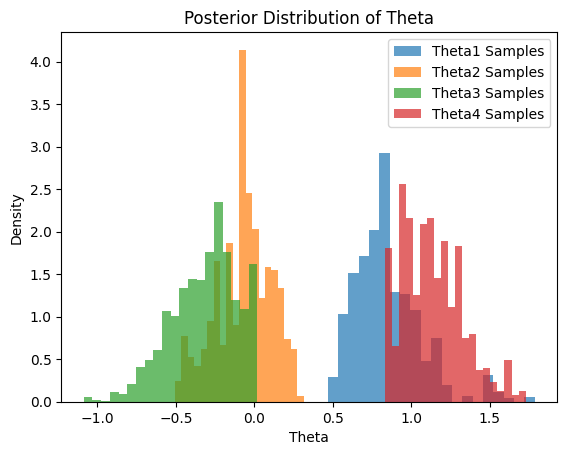

Mean of theta1: 0.8506456017494202
Mean of theta2: -0.06790240854024887
Mean of theta3: -0.32110336422920227
Mean of theta4: 1.1341630220413208
[[0.6856707071570237, 0.07479219888600463], [-0.05770537881008486, 0.8706924686393791]]


In [106]:
X = torch.stack(positions)
# Observations (y): binary data from a Bernoulli distribution
y = torch.stack(observations)

# Define prior parameters
mu = torch.tensor([torch.mean(torch.tensor(pomdp_env.stretch_range)),
                torch.mean(torch.tensor(pomdp_env.shear_range)),
                torch.mean(torch.tensor(pomdp_env.shear_range)),
                torch.mean(torch.tensor(pomdp_env.stretch_range))])
sigma = torch.eye(4) * 0.2  # Identity covariance matrix

# Run Metropolis-Hastings
samples = metropolis_hastings(X,y, num_samples=50000, burn_in=50000, mu=mu, sigma=sigma, proposal_std=0.2)

# Analyze and visualize results
import matplotlib.pyplot as plt

# plot histograms of the samples for each of the four parameter corresponding to samples[:,0], samples[:,1], samples[:,2], samples[:,3]
plt.hist(samples[:,0].numpy(), bins=20, density=True, alpha=0.7, label='Theta1 Samples')
plt.hist(samples[:,1].numpy(), bins=20, density=True, alpha=0.7, label='Theta2 Samples')
plt.hist(samples[:,2].numpy(), bins=20, density=True, alpha=0.7, label='Theta3 Samples')
plt.hist(samples[:,3].numpy(), bins=20, density=True, alpha=0.7, label='Theta4 Samples')
plt.title("Posterior Distribution of Theta")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()

print("Mean of theta1:", samples[:,0].mean().item())
print("Mean of theta2:", samples[:,1].mean().item())
print("Mean of theta3:", samples[:,2].mean().item())
print("Mean of theta4:", samples[:,3].mean().item())

print(pomdp_env.transformation_matrix)

# Mean of theta1: 0.8506456017494202
# Mean of theta2: -0.06790240854024887
# Mean of theta3: -0.32110336422920227
# Mean of theta4: 1.1341630220413208
# [[0.6856707071570237, 0.07479219888600463], [-0.05770537881008486, 0.8706924686393791]]